In [1]:
# import all necessary libraries
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
#upload the dataset
df = pd.read_csv('data4/judge-1377884607_tweet_product_company.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

In [4]:
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive


In [5]:
#replacing the product column 
df_replace = {'iPad': 'apple', 'Apple': 'apple', 'iPad or iPhone App': 'apple', 'Google': 'google', 'iPhone': 'apple',
       'Other Google product or service': 'google', 'Android App': 'google', 'Android': 'google',
       'Other Apple product or service': 'apple'}
df['product'].replace(df_replace, inplace=True)

In [6]:
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,apple,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,apple,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,apple,positive
3,@sxsw I hope this year's festival isn't as cra...,apple,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,google,positive


In [7]:
#seeing what the product value count is
df['product'].value_counts(1)

apple     0.731996
google    0.268004
Name: product, dtype: float64

In [8]:
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [9]:
#drop text column
df.dropna(subset=['text'], inplace=True)



In [10]:
#seeing what the sentiment calue count is
df.sentiment.value_counts()

No emotion toward brand or product    5388
positive                              2978
negative                               570
I can't tell                           156
Name: sentiment, dtype: int64

In [11]:
pos = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')].drop('product', axis=1)
pos.head()



,text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


In [12]:
#replacing the negative and positive
pos.sentiment.replace(('negative', 'positive'), (1, 0), inplace=True)
pos.sentiment.value_counts(normalize=True)

0    0.839346
1    0.160654
Name: sentiment, dtype: float64

In [13]:
product_sentiment = df[['sentiment','product']].value_counts().unstack(level=-1)
product_sentiment

product,apple,google
sentiment,,
I can't tell,7,2
No emotion toward brand or product,65,26
negative,388,131
positive,1949,723


<AxesSubplot:xlabel='sentiment'>

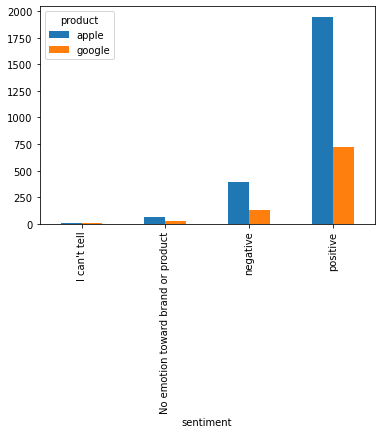

In [14]:
product_sentiment.plot(kind='bar')

In [15]:
# split the data for training and testing
X = pos.text
y = pos.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

In [16]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
df_cv = pd.DataFrame(cv_X_train.toarray(), columns=cv.get_feature_names())

<Figure size 1440x1440 with 0 Axes>

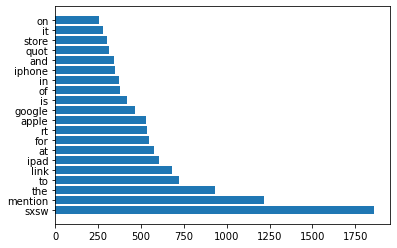

<Figure size 1440x1440 with 0 Axes>

In [17]:
#making a bar graph showing the most used words
plt.barh(df_cv.sum().sort_values(ascending=False)[:20].index, df_cv.sum().sort_values(ascending=False)[:20]);


plt.figure(figsize=(20,20))

In [18]:
sw = stopwords.words('english')

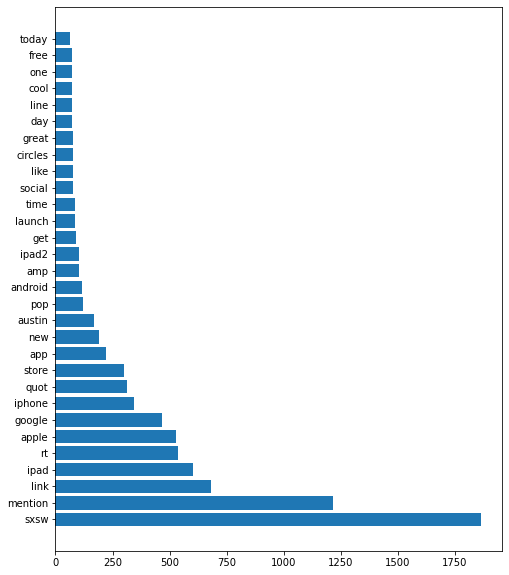

In [19]:
sw_cv = CountVectorizer(stop_words=sw)
sw_cv_X_train = sw_cv.fit_transform(X_train)
sw_cv_X_test = sw_cv.transform(X_test)
sw_df_cv = pd.DataFrame(sw_cv_X_train.toarray(), columns=sw_cv.get_feature_names())
plt.figure(figsize=(8,10))
plt.barh(sw_df_cv.sum().sort_values(ascending=False)[:30].index, sw_df_cv.sum().sort_values(ascending=False)[:30]);

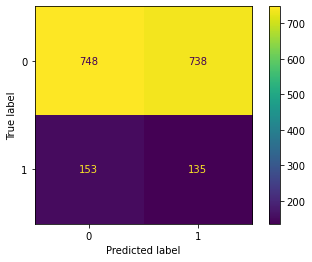

In [20]:
#making a DummyClassifier
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy_sm = dummy.predict(X_test)
plot_confusion_matrix(estimator=dummy, X=X_test, y_true=y_test);

In [21]:
# This function the correct Part of Speech so the Lemmatizer in the next function can be more accurate.
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
sw = stopwords.words('english')

In [23]:
def tweet_prep(tweet, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [24]:
#import nltk
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\czolp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\czolp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
token_tweets = [tweet_prep(tweet, sw) for tweet in X_train]





In [26]:
token_tweets[100]

'mention iphone app awesome lineup amaze really look forward hang guy sxsw mention'

In [27]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(token_tweets)
X_test_vec = cv.transform(X_test)

In [28]:
df_cv = pd.DataFrame(X_train_vec.toarray(), columns=cv.get_feature_names())

In [29]:
df_cv.sum().sort_values(ascending=False)



sxsw             1864
mention          1219
ipad              711
link              683
rt                536
                 ... 
illegal             1
illmakeitwork       1
im                  1
imac                1
zzzs                1
Length: 3358, dtype: int64

We are accurate on 85.57000000000001% of our predictions.
We identified 98.11999999999999% of the negative tweets.


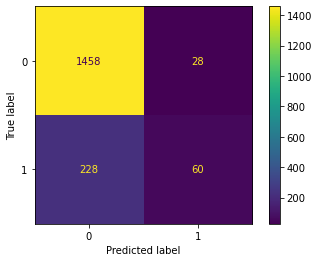

In [30]:
#making a MultinomialNB model
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_test_vec)
print(f'We are accurate on {100*round(accuracy_score(y_test, y_hat),4)}% of our predictions.')
mnb_cm = confusion_matrix(y_test, y_hat)
print(f'We identified {100*round(mnb_cm[0][0] / sum(mnb_cm[0]),4)}% of the negative tweets.')
plot_confusion_matrix(mnb, X_test_vec, y_test);

We are accurate on 84.72% of our predictions.
We identified 98.11999999999999% of the negative tweets.


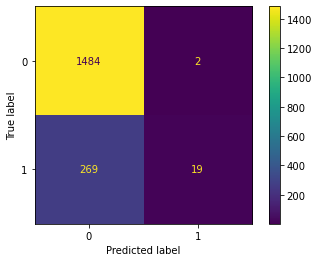

In [31]:
#making a BernoulliNB model
BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_vec.toarray(), y_train)
y_hat = bnb.predict(X_test_vec.toarray())
print(f'We are accurate on {100*round(accuracy_score(y_test, y_hat),4)}% of our predictions.')
bnb_cm = confusion_matrix(y_test, y_hat)
print(f'We identified {100*round(mnb_cm[0][0] / sum(mnb_cm[0]),4)}% of the negative tweets.')
plot_confusion_matrix(bnb, X_test_vec.toarray(), y_test);



In [32]:
#make a smote 
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train_vec, y_train) 
smote

SMOTE(random_state=42)

In [33]:
y_train_sm.value_counts()



0    1492
1    1492
Name: sentiment, dtype: int64

We are accurate on 78.97% of our predictions
We identified 84.32% of the negative tweets


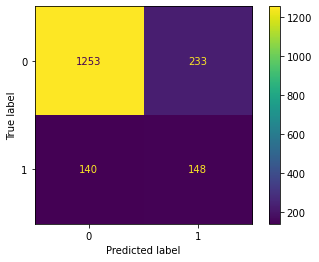

In [34]:
#making a MultinomialNB model
sm_mnb = MultinomialNB()
sm_mnb.fit(X_train_sm, y_train_sm)
sm_y_hat = sm_mnb.predict(X_test_vec)
print(f'We are accurate on {100*round(accuracy_score(y_test, sm_y_hat),4)}% of our predictions')
sm_cm = confusion_matrix(y_test, sm_y_hat)
print(f'We identified {100*round(sm_cm[0][0] / sum(sm_cm[0]),4)}% of the negative tweets')
plot_confusion_matrix(sm_mnb, X_test_vec, y_test);



In [35]:
#make a tfidf vectorizer
tfidf = TfidfVectorizer()
tfidf_X_train_ = tfidf.fit_transform(token_tweets)
tfidf_X_test = tfidf.transform(X_test)

In [36]:
smote2 = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm2, y_train_sm2 = smote.fit_sample(tfidf_X_train_, y_train)

We are accurate on 79.14% of our predictions
We identified 83.31% of the negative tweets


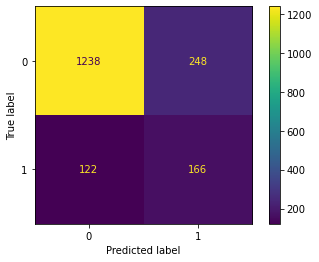

In [37]:
#making a MultinomialNB model
tfidf_mnb = MultinomialNB()
tfidf_mnb.fit(X_train_sm2, y_train_sm2)
tfidf_y_hat = tfidf_mnb.predict(tfidf_X_test)
print(f'We are accurate on {100*round(accuracy_score(y_test, tfidf_y_hat),4)}% of our predictions')
tfidf_cm = confusion_matrix(y_test, tfidf_y_hat)
plot_confusion_matrix(tfidf_mnb, tfidf_X_test, y_test);
print(f'We identified {100*round(tfidf_cm[0][0] / sum(tfidf_cm[0]),4)}% of the negative tweets')

In [38]:
#make a decisiontreeclassifier
tree = DecisionTreeClassifier()



In [39]:
tree.fit(X_train_sm2, y_train_sm2)

DecisionTreeClassifier()

In [40]:
y_pred_sm2 = tree.predict(tfidf_X_test)

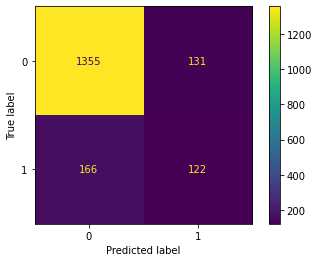

In [41]:
plot_confusion_matrix(tree, tfidf_X_test, y_test)